In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from scipy.spatial import procrustes
import scipy
import pdb
import math

from IPython.core.debugger import Tracer

#matplotlib tk
%matplotlib inline

In [2]:


pi=math.pi
cos=math.cos
sin=math.sin

def rot(theta):
    return np.array([[cos(theta),sin(theta),0],     
                     [-sin(theta),cos(theta),0],
                      [0,0,1] ])


def get_eigenvalues(triangle):
    """
    Computes and returns the deformation gradient
    matrix as well as its eigenvalues
    """
    
    # Reference triangle #
    #Coordinates of an equilateral traingle are (0,0),(0,2a),(1,a*sqrt(3))

    ref_triangle = np.array([[-0.5,0],[0.5,0],[0,0.5*sqrt(3)]])
    #plt.triplot(ref_triangle[:,0],ref_triangle[:,1],linewidth=7.0)

    # Material coordinates
    dX=np.array([      
       [ref_triangle[1][0]-ref_triangle[0][0] , ref_triangle[2][0]-ref_triangle[0][0]] ,   
       [ref_triangle[1][1]-ref_triangle[0][1] , ref_triangle[2][1]-ref_triangle[0][1]]
                ])
    

    # World coordinates
    dx=np.array([      
       [triangle[1][0]-triangle[0][0] , triangle[2][0]-triangle[0][0]] ,   
       [triangle[1][1]-triangle[0][1] , triangle[2][1]-triangle[0][1]]
                ])

    
    # The deformation matrix is F=dx*DX^(-1)

    inv_dX=np.linalg.inv(dX)
    F=np.dot(dx,np.linalg.inv(dX))
    #print("Determinant of the deformation gradient is: {0}".format(np.linalg.det(F)))


    # The goal is to find and appropriate diagonalization 
    # of F=U*F'*V.T. To properly diagonalize it we first 
    # consider A=F.T*F. Then by definition (symmetric matrix)
    # the diagonalizarion of A will give always real and non 
    # nonegative singular valures. We have, A=(VF'U.T)(UF'V.T)
    # =VF^2V.T
    
    A=F.T.dot(F)
    
    # Perform an SVD to A we get:
    
    u,s,V_tranpose=np.linalg.svd(A)
    V=V_tranpose.T
    #s,V=np.linalg.eig(A)
    #print("Determinant of eigenvectors V of FF.T is:{0}".format(np.linalg.det(V)))
    
    # The entries of F' are the square roots of s
    F_diag=np.sqrt(s)
    np.sort(F_diag)
    F_diag=np.diag(F_diag)
    
    
    # We compute  U=F*V*(F_diag)^-1
    
    F_diag_inverse=np.linalg.inv(F_diag)
    U=F.dot(V).dot(F_diag_inverse)
    
    # Checking if indeed F=UF'V.T
    #print(np.allclose(F,U.dot(F_diag).dot(V.T)))
    #print(np.linalg.det(U))
    
    # Calculate rotation matrix and calculate rotation angle(z-axis) (Source: http://nghiaho.com/?page_id=846)
    R=np.dot(V,U.T)
    
    # Checking for reflection case
    if np.linalg.det(R)<0:
        V[1,:]*=-1
        R=np.dot(V,U.T)
    
    
    rotation_angle=180/pi*np.arctan2(R[1,0],R[0,0])
    
    
    # now extract the sign of the singular values of F 
    # by sign(u_i*v_i)*F_diag
    signs=[-1 if np.sign(U[:,i].dot(V[:,i]))<0 else 1 for i in range(A.shape[1])]
    eig=[signs[i]*F_diag[i][i] for i in range(A.shape[1])]
    factor=1

    for i in range(A.shape[1]):
        factor*=np.sqrt(F_diag[i,i])

    # To make the eigenvalues scale invariant multiply them with
    # 1/P(l_i)
    for i in range(len(eig)):
        eig= np.multiply(eig,1/(factor)**(1/2) if factor!=0 else 0)

            
    #print(" Eigenvalues of F are : {0}".format(eig))  
   


   # Treat change of sign due to rotation
    if  90 < rotation_angle <= 180 or -180 <= rotation_angle <= -90:
        eig*=-1
    
    
    
    return eig,F,U,rotation_angle


def get_barycenter(triangle):
    x_c,y_c=0,0
    for i in triangle:
        x_c+=i[0]
        y_c+=i[1]
    x_c/=3
    y_c/=3
    return x_c,y_c

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
  
    return np.arccos(np.dot(v1, v2))*180/pi

def py_ang(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'    """
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    if v2[0]>0:
        return np.arctan2(sinang, cosang)*180/pi
    else :
        return 180+ np.arctan2(sinang, cosang)*180/pi


Determinant of eigenvectors V of FF.T is:1.0
True
1.0
 Eigenvalues of F are : [4.0, 4.0]
 Singular values of F are : 4.0,4.0
Angle of rotation is: 0.0
Determinant of the deformation gradient is: 15.999999999999998
Determinant of the U is: 1.0
1.0
0.0
Determinant of rotation matrix is : [[ 1.  0.]
 [ 0.  1.]] 


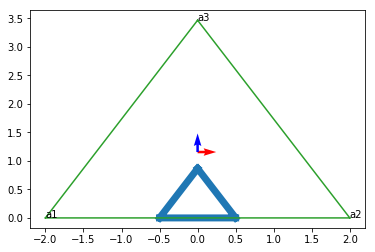

In [3]:


# Reference triangle #
#Coordinates of an equilateral traingle are (0,0),(0,2a),(1,a*sqrt(3))

ref_triangle = np.array([[-0.5,0],[0.5,0],[0,0.5*sqrt(3)]])
plt.triplot(ref_triangle[:,0],ref_triangle[:,1],linewidth=7.0)

# Material coordinates
dX=np.array([      
   [ref_triangle[1][0]-ref_triangle[0][0] , ref_triangle[2][0]-ref_triangle[0][0]] ,   
   [ref_triangle[1][1]-ref_triangle[0][1] , ref_triangle[2][1]-ref_triangle[0][1]]
            ])

#n=['A1','A2','A3']
#for i, txt in enumerate(n):
#    plt.annotate(txt, (ref_triangle[i,0],ref_triangle[i,1]))
#
#Slighlty deformed triangle #
deform_triangle=4*np.array([[-0.5,0,0],[0.5,0,0],[0.0,0.5*sqrt(3),0]])

# Include rotation

#deform_triangle=np.dot(rot(pi/3),deform_triangle.T).T

# World coordinates
dx=np.array([      
   [deform_triangle[1][0]-deform_triangle[0][0] , deform_triangle[2][0]-deform_triangle[0][0]] ,   
   [deform_triangle[1][1]-deform_triangle[0][1] , deform_triangle[2][1]-deform_triangle[0][1]]
            ])
n=['a1','a2','a3']
for i, txt in enumerate(n):
    plt.annotate(txt, (deform_triangle[i,0],deform_triangle[i,1]))


plt.triplot(deform_triangle[:,0],deform_triangle[:,1])




# The deformation matrix is F=dx*DX^(-1)

inv_dX=np.linalg.inv(dX)
F=np.dot(dx,inv_dX)


# The goal is to find and appropriate diagonalization 
# of F=U*F'*V.T. To properly diagonalize it we first 
# consider A=F.T*F. Then by definition (symmetric matrix)
# the diagonalizarion of A will give always real and non 
# nonegative singular valures. We have, A=(VF'U.T)(UF'V.T)
# =VF^2V.T

A=F.T.dot(F)

# Perform an SVD to A we get:

u,s,V_tranpose=np.linalg.svd(A)
V=V_tranpose.T
#s,V=np.linalg.eig(A)
print("Determinant of eigenvectors V of FF.T is:{0}".format(np.linalg.det(V)))

# The entries of F' are the square roots of s
F_diag=np.sqrt(s)
np.sort(F_diag)
F_diag=np.diag(F_diag)


# We compute  U=F*V*(F_diag)^-1

F_diag_inverse=np.linalg.inv(F_diag)
U=F.dot(V).dot(F_diag_inverse)

# Checking if indeed F=UF'V.T
print(np.allclose(F,U.dot(F_diag).dot(V.T)))
print(np.linalg.det(U))


# now extract the sign of the singular values of F 
# by sign(u_i*v_i)*F_diag

signs=[-1 if np.sign(U[:,i].dot(V[:,i]))<0 else 1 for i in range(A.shape[1])]
eig=[signs[i]*F_diag[i][i] for i in range(A.shape[1])]

print(" Eigenvalues of F are : {0}".format(eig))    
print(" Singular values of F are : {0},{1}".format(F_diag[0][0],F_diag[1][1]))    
#plt.quiver(*get_barycenter(deform_triangle),s[0]*U[:,0],color=['r'],scale_units='xy',scale=2 )
#plt.quiver(*get_barycenter(deform_triangle),s[1]*U[:,1],color=['b'],scale_units='xy',scale=1 )


#if np.linalg.det(U)>0:
#    np.multiply(U[:,0],-1)


barycenter=get_barycenter(deform_triangle)
plt.quiver(barycenter[0],barycenter[1],np.diagonal(F_diag)[0]*U[:,0],
                                             np.diagonal(F_diag)[1]*U[:,1],
                                            color=['r','b'],scale_units='width')


# Finding angle of rotationa matrix (http://nghiaho.com/?page_id=846)
R=np.dot(V,U.T)

print("Angle of rotation is: {0}".format(180/pi*np.arctan2(R[1,0],R[0,0])))

#plt.quiver(*get_barycenter(deform_triangle),V[:,0],V[:,1],color=['y','b'],scale=12)
print("Determinant of the deformation gradient is: {0}".format(np.linalg.det(F)))
print("Determinant of the U is: {0}".format(np.linalg.det(U)))
print(np.sign(U[:,1].dot(V[:,1])))
print(180/pi*np.arccos(np.dot(U[:,1],V[:,1])))
print("Determinant of rotation matrix is : {0} ".format(np.round(np.dot(R,R.T))))

In [4]:
pts = [(162, 137), (211, 158), (89, 133)]
Polygon(pts)
x=deform_triangle[:,0]
y=deform_triangle[:,1]
x,deform_triangle[:,0]
rot(pi).dot(deform_triangle)

array([[ 2.        ,  0.        ,  0.        ],
       [-2.        ,  0.        ,  0.        ],
       [ 0.        ,  3.46410162,  0.        ]])

[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026  0.503144 ] 171.011454045
[ 1.9875026 

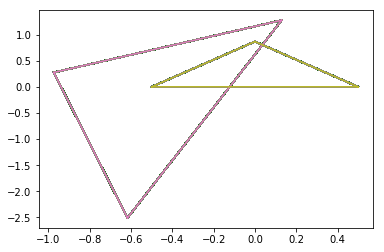

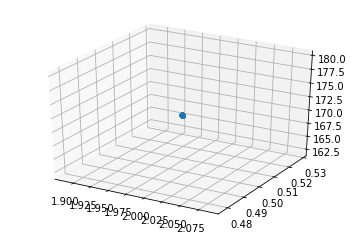

In [127]:
#  Testing
eigenvalues=[]
angles=[]
for i in np.arange(0,500,1):
    #test_triangle= np.multiply(1,np.array([[-0.5,0,0],[0.5,0.0 ,0 ],[0,0.5*sqrt(3),0]]))
    #test_triangle=np.random.normal(0,1,(3,3))
    test_triangle=np.array([[ 0.12941855,  1.27407225,  0.        ],
       [-0.97405352,  0.27473127,  0.        ],
       [-0.61734043, -2.50838646,  0.        ]])
    rotated_triangle=np.dot(rot(0),test_triangle.T).T
    eigen,F,U,rotation_angle=get_eigenvalues(rotated_triangle)
    eigenvalues.append([eigen[0],eigen[1]])
    plt.triplot(rotated_triangle[:,0],rotated_triangle[:,1])
    plt.triplot(ref_triangle[:,0],ref_triangle[:,1])
    print(eigen,rotation_angle)
    angles.append(rotation_angle)
eigenvalues=np.array(eigenvalues)
angles=np.array(angles)
# SO F=R*U (polar decomposition), here U=sqrt(A) (A=F.T*F)
# so R=F*inv(U), where R is an orthonormal matric (R*R.T=I)
figure=plt.figure()
ax=figure.add_subplot(111,projection='3d')
ax.scatter(eigenvalues[:,0],eigenvalues[:,1],angles)
#ax.xlabel('eigenvalue1')
#U=np.sqrt(np.dot(F.T,F))
#R=F*np.linalg.inv(U)

#U=F.dot(V).dot( np.linalg.inv(np.diag(abs(eigen))))


# So having the eigenvalues of F we now the principal strecthes 
# of the shape which are unique for any triangural form


#barycenter=get_barycenter(rotated_triangle)
#plt.quiver(*barycenter,U[:,1],angles='xy',color=['r','b'],scale_units='xy',scale=3 )
#print(U)

In [110]:
#for i in range(10):
#    triangle=  np.multiply(2,np.array([[-0.5,0,0],[0.5,i,0],[0.0,0.5*sqrt(3)]]))
#    rotate_triangle=np.dot(triangle,rot(i*pi/4))
#    eigen,f=get_eigenvalues(rotate_triangle)
#    plt.triplot(rotate_triangle[:,0],rotate_triangle[:,1])
#    print(eigen)
#plt.triplot(ref_triangle[:,0],ref_triangle[:,1])
#eigen,f=get_eigenvalues(rotate_triangle)


In [7]:
get_eigenvalues(deform_triangle)

(array([ 1.,  1.]), array([[ 2.        ,  3.46410162],
        [-3.46410162,  2.        ]]), array([[ 0.8660254, -0.5      ],
        [ 0.5      ,  0.8660254]]), -59.999999999999993)

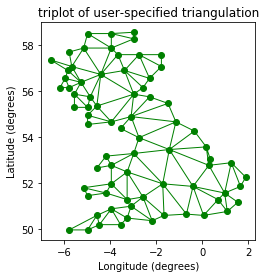

In [8]:
xy = np.asarray([
    [-0.101, 0.872], [-0.080, 0.883], [-0.069, 0.888], [-0.054, 0.890],
    [-0.045, 0.897], [-0.057, 0.895], [-0.073, 0.900], [-0.087, 0.898],
    [-0.090, 0.904], [-0.069, 0.907], [-0.069, 0.921], [-0.080, 0.919],
    [-0.073, 0.928], [-0.052, 0.930], [-0.048, 0.942], [-0.062, 0.949],
    [-0.054, 0.958], [-0.069, 0.954], [-0.087, 0.952], [-0.087, 0.959],
    [-0.080, 0.966], [-0.085, 0.973], [-0.087, 0.965], [-0.097, 0.965],
    [-0.097, 0.975], [-0.092, 0.984], [-0.101, 0.980], [-0.108, 0.980],
    [-0.104, 0.987], [-0.102, 0.993], [-0.115, 1.001], [-0.099, 0.996],
    [-0.101, 1.007], [-0.090, 1.010], [-0.087, 1.021], [-0.069, 1.021],
    [-0.052, 1.022], [-0.052, 1.017], [-0.069, 1.010], [-0.064, 1.005],
    [-0.048, 1.005], [-0.031, 1.005], [-0.031, 0.996], [-0.040, 0.987],
    [-0.045, 0.980], [-0.052, 0.975], [-0.040, 0.973], [-0.026, 0.968],
    [-0.020, 0.954], [-0.006, 0.947], [ 0.003, 0.935], [ 0.006, 0.926],
    [ 0.005, 0.921], [ 0.022, 0.923], [ 0.033, 0.912], [ 0.029, 0.905],
    [ 0.017, 0.900], [ 0.012, 0.895], [ 0.027, 0.893], [ 0.019, 0.886],
    [ 0.001, 0.883], [-0.012, 0.884], [-0.029, 0.883], [-0.038, 0.879],
    [-0.057, 0.881], [-0.062, 0.876], [-0.078, 0.876], [-0.087, 0.872],
    [-0.030, 0.907], [-0.007, 0.905], [-0.057, 0.916], [-0.025, 0.933],
    [-0.077, 0.990], [-0.059, 0.993]])
x = np.degrees(xy[:, 0])
y = np.degrees(xy[:, 1])

triangles = np.asarray([
    [67, 66,  1], [65,  2, 66], [ 1, 66,  2], [64,  2, 65], [63,  3, 64],
    [60, 59, 57], [ 2, 64,  3], [ 3, 63,  4], [ 0, 67,  1], [62,  4, 63],
    [57, 59, 56], [59, 58, 56], [61, 60, 69], [57, 69, 60], [ 4, 62, 68],
    [ 6,  5,  9], [61, 68, 62], [69, 68, 61], [ 9,  5, 70], [ 6,  8,  7],
    [ 4, 70,  5], [ 8,  6,  9], [56, 69, 57], [69, 56, 52], [70, 10,  9],
    [54, 53, 55], [56, 55, 53], [68, 70,  4], [52, 56, 53], [11, 10, 12],
    [69, 71, 68], [68, 13, 70], [10, 70, 13], [51, 50, 52], [13, 68, 71],
    [52, 71, 69], [12, 10, 13], [71, 52, 50], [71, 14, 13], [50, 49, 71],
    [49, 48, 71], [14, 16, 15], [14, 71, 48], [17, 19, 18], [17, 20, 19],
    [48, 16, 14], [48, 47, 16], [47, 46, 16], [16, 46, 45], [23, 22, 24],
    [21, 24, 22], [17, 16, 45], [20, 17, 45], [21, 25, 24], [27, 26, 28],
    [20, 72, 21], [25, 21, 72], [45, 72, 20], [25, 28, 26], [44, 73, 45],
    [72, 45, 73], [28, 25, 29], [29, 25, 31], [43, 73, 44], [73, 43, 40],
    [72, 73, 39], [72, 31, 25], [42, 40, 43], [31, 30, 29], [39, 73, 40],
    [42, 41, 40], [72, 33, 31], [32, 31, 33], [39, 38, 72], [33, 72, 38],
    [33, 38, 34], [37, 35, 38], [34, 38, 35], [35, 37, 36]])

# Rather than create a Triangulation object, can simply pass x, y and triangles
# arrays to triplot directly.  It would be better to use a Triangulation object
# if the same triangulation was to be used more than once to save duplicated
# calculations.
plt.figure()
plt.gca().set_aspect('equal')
plt.triplot(x, y, triangles, 'go-', lw=1.0)
plt.title('triplot of user-specified triangulation')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

plt.show()

In [7]:
quality

NameError: name 'quality' is not defined

In [6]:
a

{0: 0, 1: 2, 2: 4, 3: 6, 4: 8}